## Tutorial: Measuring dv/v in the time, frequency, and wavelet Domains
In this notebook, we aim to reproduce the essential results in (Yuan et al. 2021). The results are mainly included into three numerical contexts, such as 1) homogeneous half-space configuration; 2) layered half-space configuration; and 3) dv/v-depth-sensitivity investigation. We are going to apply three groups of methods, including 1) WCC, TS, and DTW in time domain for raw waveforms; 2) MWCS in frequency domain, WCS, WTS, and WTDTW in wavelet domain for narrow frequency bands; 3) WCS, WTS, and WTDTW in wavelet domain for each individual frequency, to obtain dv/v results for each of three examples. We will introduce the algorithms in all mentioned approaches at first and then perform the realizations of three cases. 

This tutorial is written by Congcong Yuan. Please reach out to him via cyuan@fas.harvard.edu if having any question regarding the implementation of the following monitoring approaches. More details about the description of the following algorithms and their implementations can be found in the following manuscript: 

`Yuan, C., Bryan, J., Denolle, M. Comparing appraoches to measuring phase variations in time, frequency, wavelet domains, in preparation for Geophysical Journal International` 

----------------------------
The outline of the tutorial is shown as follows:

1. Monitoring algorithms for dv/v measurements

    1.1-1.6: seven available approaches to estimating dv/v
    
2. Configure the environment for computing dv/v
3. Define the functions for plotting waveform and dv/v results
4. Load simulation data at various settings for testing monitoring algorithms
5. Homogeneous half-space setting (example 01)
6. Layered half-space setting (example 02) 

    6.1-6.3: Autocorrelation case - uniform change, shallow change, and deep change
    
    6.4-6.6: Crosscorrelation case - uniform change, shallow change, and deep change
    
7. Depth sensitivity to velocity change (example 03)
    
    7.1 Autocorrelation case
    
    7.2 Crosscorrelation case

### 1. Monitoring algorithms for dv/v measurements
#### 1.1. Windowed Cross Correlation - WCC
The main procedure of the idea is to compute the dot product at each lapse time by sliding one waveform on the other waveform. The implementation can be mathematically defined as:
$$R(\delta\tau_i)=\frac{\int_{t_{i-w/2}}^{t_{i+w/2}}u_0(t)u(t+\delta\tau_i)dt}{\sqrt{\int_{t_{i-w/2}}^{t_{i+w/2}}u_0(t)^2dt\int_{t_{i-w/2}}^{t_{i+w/2}}u(t)^2dt}}$$
where $R$ is the correlation coefficient, $\delta\tau_i$ denotes the time shift that corresponds to $i^{th}$ lapse time $\tau_{i}$. $w$ represents the defined window length on which the crosscorrelation works. The window length is at least two periods of waveforms. $u_0$ and $u$ are considered as the reference and current waveforms for the comparison.

#### 1.2. Trace Stretching - ST
In the practice of TS, the time axis of one trace is rescaled with one stretch factor $\epsilon$ as:
$$t'=t+\tau,$$
$$\tau=\epsilon{t}.$$
where the stretch factor is equivalent to the negative homogeneous velocity perturbation.

#### 1.3. Dynamic Time Warping - DTW
Similar to the TS, we have to stretch one trace in DTW by applying time-varying shifts $s(t)$ to one trace $u(t_0)$. $t'$ would become $t+s(t)$. The shifts are lapse-time dependent rather than one constant in TS. Our target is to estimate the optimal shift function minimizing the misfit between two traces, which leads to $u(t)\approx{u(t_0)}$. Alike to the classic optimization problem, in the first step we define a mean-squared-error function between the two traces:
$$e(t,\tau)=(u(t)-u_0(t+\tau))^2,$$
where the misfit function could be used with another norm, such as mean absolute error. We define $\tau$ is a vector of time lags from $-\tau_{max}$ to $+\tau_{max}$ with the same sampling rate as the trace ($dt=d\tau$).
In the second step, we shall accumulate the computed errors in lapse time and time lag:
$$
    d(t_1,\tau) = e(t_1,\tau), \\ 
    d(t_i,\tau_j) = e(t_i,\tau_j)+min\begin{cases}
               d(t_{i-1},\tau_{j-1})\\
               d(t_{i-1},\tau_{j})\\
               d(t_{i-1},\tau_{j+1})
            \end{cases},
$$
where $d(t,\tau)$ is called as the distance function. $i$ is an integer that belongs to $[2,N]$, and $N$ is the number of time samples in the trace; $j$ is an integer that belongs to $[2, M-1]$, and $M$ is the length of the $\tau$ vector. It is therefore not hardly understood that the distance function is constrained by the maximum distance $\tau_{max}$ and maximum time interval $dt$. In practice, we have to ensure the time shifts resulted from the $dv/v$ within the $\tau_{max}$. Additionally, in order to limit the maximum $dv/v$, we apply the boundary conditions on the above equation and rewrite as:
$$
    d(t_1,\tau) = e(t_1,\tau), \\ 
    d(t_i,\tau_j) = e(t_i,\tau_j)+min\begin{cases}
               d(t_{i-b},\tau_{j-1})+\sum_{c=i-1}^{i-b+1}{e(t_c,\tau_{j-1})}\\
               d(t_{i-1},\tau_{j})\\
               d(t_{i-b},\tau_{j+1}+\sum_{c=i-1}^{i-b+1}{e(t_c,\tau_{j+1})})
            \end{cases},
$$
where the integer parameter $b\geq2$ and the integer $i$ belongs to $[b+1,N]$. The maximum time step here becomes $d\tau/b$ instead of $dt$, which may constrain the maximum $dv/v$ by setting the parameter $b$. For example, the maximum $\delta{v}/v$ becomes 50$\%$ if the parameter $b$ equals to $2$. 

After the accumulation, the backtracking is performed to find the optimal warping path minimizing the accumulated distance. We start finding the minimum with the last time sample $N$ in time window and recursively back to the first time sample $1$. During finding the time lags for previous time samples, only three time lags are compared for the minimum one. The process of the entire backtracking can be expressed as:
$$
    D(N)=\arg\min\limits_{\tau}d(t_N,\tau), \\
    D(i)=\arg\min\limits_{\tau\in{[D(i)-1,D(i),D(i)+1]}}d(t_N,\tau).
$$
where the integer $i$ belongs to $[1,N-1]$. The searched warping path gives the set of lags that optimally minimizing two traces. The $dv/v$ is then obtained by the linear regression of these lags over lapse times.

#### 1.4. Moving Window Cross Spectral - MWCS
Different from the WCC, each lag would be calculated in frequency domain rather than time domain. Provided with two traces, we extract the windowed pair of waveforms at the same lapse time and calculate their cross-spectrum as follows:
$$X(f)=F_0(f)F^{\ast}(f),$$
where $F_0(f)$ and $F^{\ast}(f)$ are Fourier-transformed representations of the windowed waveforms, $f$ is frequency in $Hz$ and $\ast$ denotes complex conjugation. After the cross-correlation of two Fourier transformations, $X(f)$ is expressed in the form as:
$$X(f)=|X(f)|e^{i\phi(f)},$$
where $|X(f)|$ and $\phi(f)$ represents the amplitude and phase of the complex cross spectrum. The time shifts can be determined as a slope of a linear regression between phases of the cross spectrum and frequencies according to the equation written as:
$$\phi(f)=2\pi\delta{t}f.$$
where $\delta{t}$ is the time shift of the lapse time centered the time window. With the above equation, we continually obtain time shifts by sliding a time window over the coda waves. Under the assumption of homogeneous velocity change of the space sampled by coda waves, we can further gain a $dv/v$ by regressing the measured time shifts over the lapse times.

### 1.5. Wavelet cross spectrum - WCS
As only continuous wavelet transform (CWT) is applied, we define the discrete version of CWT by the following convolution:
$$
    W_n{(s)}=\sum_{n'=1}^{N}{x_{n'}\psi^{\ast}{[\frac{(n'-n)\delta{t}}{s}]}}, \\
    \psi{[\frac{(n'-n)\delta{t}}{s}]}=(\frac{\delta{t}}{s})^{1/2}\psi_0{[\frac{(n'-n)\delta{t}}{s}]},
$$
where $x_n$ is a discrete time series with a uniform time interval $\delta{t}$, $n$ is an integer from $1$ to $N$. $\psi_{n,s}$ is the normalized wavelet with the unit energy, which is created by varying the scale $s$ and translating the localized time index $n$ of the mother wavelet $\psi_0$. After the above transform, one can construct an image $W_{n,s}$ with both the signal amplitude varying along the scale and time. To accelerate the computation, the transform can be approximated by performing the convolution of each scale for all time samples simultaneously with a discrete Fourier transform. Each scale $s$ in $W_{n,s}$ can be easily converted to the Fourier equivalent frequency $f$ for different exhibitions.

To compare two time series in the frequency- and time-domain, analogous to the Fourier cross-spectrum, one can implement the wavelet cross-spectrum (WCS) or cross wavelet transform to extract the phase delays for each frequency and time sample of the wavelet transform function (Hudgins et al. 1993; Torrence & Compo 1998). Recently, Mao et al. (2019) extended the WCS technique to the seismic interferometry for measuring the time shifts between two seismic waveforms, the WCS of which is calculated with the equation as:
$$WCS_n(s)=<W_{n}^{X}(s)W_{n}^{Y}(s)^{\ast}>,$$
where $W^{X}$ and $W^{Y}$ are the CWTs of two time series $X$ and $Y$. As Fourier cross spectrum, the obtained $WCS$ is complex valued and hence can be decomposed into amplitude $|WCS_n{(s)}|$ and phase $\phi_n{(s)}$:
$$
    WCS_n(s) =|WCS_n{(s)}|e^{n\phi_n{(s)}}, \\
    |WCS_n{(s)}| = |W_{n}^{X}(s)|\cdot|W_{n}^{Y}(s)|, \\
    \phi_n{(s)} = \phi_n^{X}{(s)}-\phi_n^{Y}{(s)}.
$$
where the amplitude of cross-spectrum $|WCS_n{(s)}|$ is obtained as the dot product between the amplitude of waveform $X$, $|W_{n}^{X}(s)|$ and the amplitude of waveform $Y$, $|W_{n}^{Y}(s)|$. $\phi_n{(s)}$ represents the delay between the phase of waveform $X$, $\phi_n^{X}{(s)}$ and phase of waveform $Y$, $\phi_n^{Y}{(s)}$ at time $t_i$ on a scale. The amplitude and phase of waveforms are both derived from their CWTs. A significance test can be performed to identify the region potentially affected by edge-effect artifacts (Torrence and Compo, 2003; Maraun and Kurths, 2004), which would be negligible for the following extraction of time shifts. As one can achieve the equivalent frequency to each scale, we can represent the phase delays $\phi_n{(s)}$ as $\phi_n{(f)}$. Therefore, the time shifts can be individually derived at each time sample and frequency as the following equation, instead of regressing phase differences along frequencies in MWCS. 
$$\delta{t}_n{(f)}=\frac{\phi_n{(f)}}{2\pi{f}}.$$

Upon the time shifts are gained, under the assumption of homogeneous velocity change, the $dv/v$ of each frequency can be further derived by the linear regression of the time shifts within the defined time window.

#### 1.6. Wavelet Transform Stretching - WTS & Wavelet Transform Dynamic Time Warping - WTDTW
The time series reconstruction from the wavelet domain can be obtained with the following equation:
$$\overline{X}_n=\frac{\delta{j}\delta{t^{1/2}}}{C_\delta{\psi_0{(0)}}}\sum_{j=j1}^{j2}\frac{\mathcal{R}\{W_n{(s_j)}\}}{s_j^{1/2}},$$
where $\mathcal{R}$ denotes the real part. The factor $\psi_0{(0)}$ removes the energy scaling. The factor $C_\delta$ is derived by reconstructing a $\delta$ function from its wavelet transform. It is a constant for each wavelet function and its derivation is referred to \citep{Torrence1998tutorial}. The $\overline{X}$ is the reconstructed time series over a band from $j_1^{th}$ to $j_2^{th}$ scale or frequency. The reconstruction is performed at a specific scale or frequency when $j_1$ equals to $j_2$. In this case, the above equation is degraded into
$$
    \overline{X}_n =\alpha{\mathcal{R}\{W_n{(s_j)}\}},\\
    \alpha =\frac{\delta{j}\delta{t^{1/2}}}{C_\delta{\psi_0{(0)}}s_j^{1/2}}.
$$

Based on the reconstruction equation, we can transform the wavelet function of particular frequency or frequency band back to the corresponding time series in time domain. The wavelet transform and its reconstruction of specific frequency or frequency band is equivalent to the frequency filter in the signal processing. One natural way obtaining $\delta{v}/v$ of each frequency is applying TS or DTW on the time series filtered at each frequency with the wavelet domain. However, the reconstruction of the time series at each frequency would cost much time. We fortunately find that the real part of the wavelet transform $\mathcal{R}\{W_n\}$ is used for the reconstruction and the coefficient $\alpha$ is an independent constant, which allows us to directly use $\mathcal{R}\{W_n\}$ without considering scaling $\alpha$, since the scaling is usually ignored in extracting variations of two time series. In this way, we are permitted employing TS or DTW on the $\mathcal{R}\{W_n\}$ without additional time cost.

### 2. Configure the environment for computing dv/v

In [1]:
# add dependencies
import sys
import time
import os, glob
import numpy as np
import h5py
from noisepy.seis.application_modules.monitoring_utils import (
    wcc_dvv, 
    stretching, 
    dtw_dvv, 
    mwcs_dvv, 
    wxs_dvv, 
    wts_dvv, 
    wtdtw_dvv
)
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import EngFormatter

/Users/marinedenolle/opt/miniconda3/envs/noisepy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3. Define the functions for plotting waveform and dv/v results

In [2]:
# define functions to plot
def plot_waveform_spectra(ref, cur, para):
    """
    Plot current and reference waveforms and their spectra of energy densities. 
    
    PARAMETERS:
    ---------------
    ref: reference signal (np.array, size N)
    cur: current/perturbed signal (np.array, size N)
    t: time info. of signal (np.array, size N)
    para: a dict containing time&freq limits;
                            amplitude name (displacement/velocity/acceleration);
                            velocity perturbation.
    """
    # get parameters from a dict
    twin, freq, dt, ampstr, dvov = para['twin'], para['freq'], para['dt'], para['ampstr'], para['dvov']
    tmin, tmax = np.min(twin), np.max(twin)
    fmin, fmax = np.min(freq), np.max(freq)
    tvec = np.arange(tmin,tmax,dt)
    df = 1./dt
    
    # get the periodograms
    f, a_ref = signal.periodogram(ref, df, scaling='density')
    f, a_cur = signal.periodogram(cur, df, scaling='density')
    Arms_ref, Arms_cur = np.sqrt(a_ref), np.sqrt(a_cur)

    # get maximum amplitudes
    maxval = np.max([np.max(np.abs(cur)), np.max(np.abs(ref))])
    maxval2 = np.max([np.max(np.abs(Arms_cur)), np.max(np.abs(Arms_ref))])
    
    # start plotting
    fig, ax = plt.subplots(nrows=2, ncols=1)
    ax[0].plot(tvec, cur/maxval, 'r-', tvec, ref/maxval, 'b-', linewidth=4)
    ax[0].set_xlabel("Time (s)", fontsize=8)
    ax[0].set_ylabel("Normalized " + ampstr, fontsize=8)
    ax[0].grid(True)
    ax[0].set_title("Overlap of current and reference signals")
    ax[0].legend(('current (dv/v='+str(dvov*100)+'%)','reference'), loc='upper right', fontsize=6)
    ax[0].set_xlim((tvec.min(), tvec.max()))
    ax[0].set_ylim((-1.0, 1.0))
    ax[0].tick_params(labelsize=8)
    
    ax[1].plot(f, Arms_cur/maxval2,'r-',f, Arms_ref/maxval2,'b-',linewidth=4.)
    ax[1].set_xlabel('Frequency (Hz)', fontsize=8)
    ax[1].set_ylabel('Normalized power/frequency', fontsize=8)
    ax[1].grid(True)
    ax[0].set_title("Overlap of current and reference periodograms")
    ax[1].set_xlim((fmin,fmax))
    ax[1].set_ylim((0., 1.))
    ax[1].tick_params(labelsize=8)
    
    fig.tight_layout()
    plt.show()

def plot_dvv_case01(dvv_dict, para):
    """
    Plot the estimated dv/v for all three groups of methods
    
    PARAMETERS:
    ---------------
    dvv_dict: a dict containing the dv/v results of all three groups of methods
    para: a dict containing frequency limit; 
                            frequency bands; 
                            a vector with individual frequencies;
                            true dv/v;
                            dv/v range.
    """
    
    # get parameters from dicts
    dvv_wcc, dvv_wts, dvv_wtdtw = dvv_dict['dvv_wcc'], dvv_dict['dvv_ts'], dvv_dict['dvv_dtw']
    dvv_wcs_freqbands, dvv_wts_freqbands = dvv_dict['dvv_wcs_freqbands'],  dvv_dict['dvv_wts_freqbands']
    dvv_wtdtw_freqbands, dvv_mwcs = dvv_dict['dvv_wtdtw_freqbands'],  dvv_dict['dvv_mwcs']
    dvv_wcs_allfreqs, dvv_wts_allfreqs =  dvv_dict['dvv_wcs_allfreqs'],  dvv_dict['dvv_wts_allfreqs']
    dvv_wtdtw_allfreqs =  dvv_dict['dvv_wtdtw_allfreqs']
    
    freq, freq_bands, freq_vec = para['freq'], para['freq_bands'], para['freq_vec']
    dvov, dvov_range = para['dvov'], para['dvov_range']
    
    # start plotting
    fig, ax = plt.subplots(nrows=3, ncols=1)
    # first group of methods
    x = np.array([-0.2,1,2.2])
    x1, x2, x3 = np.array(['WCC']), np.array(['TS']), np.array(['DTW'])
    y1, y2, y3 = round(dvv_wcc, 3), round(dvv_ts, 3), round(dvv_dtw, 3)
    sz, clr, mrk1, mrk2, mrk3, lw = 35, 'k', '*', 's', 'o', 4
    ylim11, ylim21 = dvov_range[0]*100., dvov_range[1]*100.
    ax[0].scatter(x1, y1, s=sz, c=clr, marker=mrk1, linewidth=lw)
    ax[0].scatter(x2, y2, s=sz, c=clr, marker=mrk2, linewidth=lw)
    ax[0].scatter(x3, y3, s=sz, c=clr, marker=mrk3, linewidth=lw)

    ax[0].set_ylim((ylim11, ylim21))
    ax[0].tick_params(labelsize=10)
    ax[0].grid(True)
    ax[0].set_xlabel(r"Time-domain method", fontsize=10)
    ax[0].set_ylabel(r"dv/v (%)", fontsize=10)
    
    # second group of methods
    x = []
    for fb in freq_bands:
        x.append(str(fb[0])+'-'+str(fb[1]))
    x = np.asarray(x)
    y1, y2 = np.round(dvv_wcs_freqbands, 3), np.round(dvv_wts_freqbands, 3)
    y3, y4 = np.round(dvv_wtdtw_freqbands, 3), np.round(dvv_mwcs, 3)
    sz, clr1, clr2, clr3, clr4, mrk1, mrk2, mrk3, mrk4, lw = 35, 'b', 'g', 'C1', 'y', '^', 's', 'o', '*', 4
    fband_ind = np.arange(0, len(freq_bands), 1)
    ylim12, ylim22 = dvov_range[0]*100., dvov_range[1]*100.
    
    ax[1].scatter(x[fband_ind], y1[fband_ind], s=sz, c=clr1, marker=mrk1, linewidth=lw)
    ax[1].scatter(x[fband_ind], y2[fband_ind], s=sz, c=clr2, marker=mrk2, linewidth=lw)
    ax[1].scatter(x[fband_ind], y3[fband_ind], s=sz, c=clr3, marker=mrk3, linewidth=lw)
    ax[1].scatter(x[fband_ind], y4[fband_ind], s=sz, c=clr4, marker=mrk4, linewidth=lw)
    
    ax[1].legend(['WCS', 'WTS', 'WTDTW', 'MWCS'], loc='upper right', fontsize=6)
    ax[1].set_ylim((ylim12, ylim22))
    ax[1].tick_params(labelsize=10)
    ax[1].grid(True)
    ax[1].set_xlabel(r"Frequency bands (Hz)", fontsize=10)
    ax[1].set_ylabel(r"dv/v (%)", fontsize=10)
    
    # third group of methods
    x = freqvec
    y1 = np.round(dvv_wcs_allfreqs, 3)
    y2 = np.round(dvv_wts_allfreqs, 3)
    y3 = np.round(dvv_wtdtw_allfreqs, 3)
    freq_ind = np.where((x>=freq[0]) & (x<=freq[1]))[0]
    ylim13, ylim23 = dvov_range[0]*100., dvov_range[1]*100.
    
    ax[2].scatter(x[freq_ind], y1[freq_ind], s=sz, c=clr1, marker=mrk1, linewidth=lw)
    ax[2].scatter(x[freq_ind], y2[freq_ind], s=sz, c=clr2, marker=mrk2, linewidth=lw)
    ax[2].scatter(x[freq_ind], y3[freq_ind], s=sz, c=clr3, marker=mrk3, linewidth=lw)
    ax[2].legend(['WCS', 'WTS', 'WTDTW'], loc='upper right', fontsize=6)
    
    ax[2].set_xlim((x[freq_ind].min(), x[freq_ind].max()))
    ax[2].set_ylim((ylim13, ylim23))
    ax[2].tick_params(labelsize=10)
    ax[2].grid(True)
    
    ax[2].set_xlabel(r"Frequency (Hz)", fontsize=10)
    ax[2].set_ylabel(r"dv/v (%)", fontsize=10)
    
    fig.tight_layout()
    fig.show()
    
def plot_dvv_case02(dvv_dict, para):
    """
    Plot the response or sensitivity of estimated dv/v spectrum to depth of velocity change
    
    PARAMETERS:
    ---------------
    dvv_dict: a dict that contains dv/v results estimated by the WTS
    para: a dict that contains frequency limit;
                               a frequency vector;
                               true dv/v;
                               dv/v range;
                               sliding depth interval;
                               flag for ac or cc.
    """
    # get parameters from dicts
    dvv_wts_allfreqs =  dvv_dict['dvv_wts_allfreqs']
    
    freq, freq_vec = para['freq'], para['freq_vec']
    dvov, dvov_range = para['dvov'], para['dvov_range']
    
    sdep = para['sdep']
    sflag = para['sflag']

    x = freqvec
    y = dvv_wts_allfreqs
    freq_ind = np.where((x>=freq[0]) & (x<=freq[1]))[0]
    ylim1, ylim2 = dvov_range[0]*100., dvov_range[1]*100.
    ndeps, nfreqs = y.shape
    deps = np.array([i for i in range(ndeps)])*sdep
    sz, mrk, lw = 100, 's', 10
    dc1, dc2, dc3 = 0.02, 0.1, 0.
    leg_list=[]
    # start plotting
    fig = plt.figure(figsize=(26,13))
    ax = fig.add_subplot(111)
    
    for ii in range(ndeps):
        ax.scatter(x[freq_ind], y[ii,freq_ind], s=sz, c=(1.-ii*dc1, 0.+ii*dc2, 0.+ii*dc3), marker=mrk, linewidth=lw)
        leg_list.append(str('%1.1f'%(deps[ii]))+' km')
        
    # add legend
    legd = ax.legend(leg_list, loc='upper left', bbox_to_anchor=(1.,1.), ncol=1, title='Depth (km)', fontsize=30)
    legd.get_title().set_fontsize('35')
    
    ax.set_xlim((np.min(freqvec[freq_ind]), np.max(freqvec[freq_ind])))
    ax.set_xscale('log')
    if sflag == 'ac':
        ax.set_xticks([0.5, 0.7, 1.0, 2.0, 4.0, 10.0, 30.0])
    elif sflag == 'cc':
        ax.set_xticks([0.05, 0.1, 0.2, 0.4, 0.8, 1.5])
        
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    ax.set_ylim((ylim1, ylim2))
    ax.tick_params(axis='x', labelsize=35)
    ax.tick_params(axis='y', labelsize=35)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)', fontsize=40)
    if sflag == 'ac':
        ax.set_ylabel('Autocorrelation dv/v (%)', fontsize=40)
    elif sflag == 'cc':
        ax.set_ylabel('Crosscorrelation dv/v (%)', fontsize=40)
    
    fig.tight_layout()
    fig.show()   

### 4. Load simulation data at various settings for testing monitoring algorithms 

In [3]:
# the directory where the data is saved
dpath = '../example_data/Monitoring_paper_simulation_data.h5'

# read data
fp=h5py.File(dpath,'r')
fp.keys()

# data for example one - uniform change of homogeneous half space
cur_homo, ref_homo, t_homo = fp['cur_homo'][:], fp['ref_homo'][:], fp['t_homo'][:]

# data for example two - shallow, deep, and uniform changes of layered half space
# zero-offset survey geometry for autocorrelation case 
cur_half_ac_shall, ref_half_ac_shall, t_half_ac_shall = fp['cur_half_ac01'][:], fp['ref_half_ac01'][:], fp['t_half_ac01'][:]
cur_half_ac_deep, ref_half_ac_deep, t_half_ac_deep = fp['cur_half_ac02'][:], fp['ref_half_ac02'][:], fp['t_half_ac02'][:]
cur_half_ac_unif, ref_half_ac_unif, t_half_ac_unif = fp['cur_half_ac03'][:], fp['ref_half_ac03'][:], fp['t_half_ac03'][:]

# distant-offset survey geometry for crosscorrelation case
cur_half_cc_shall, ref_half_cc_shall, t_half_cc_shall = fp['cur_half_cc01'][:], fp['ref_half_cc01'][:], fp['t_half_cc01'][:]
cur_half_cc_deep, ref_half_cc_deep, t_half_cc_deep = fp['cur_half_cc02'][:], fp['ref_half_cc02'][:], fp['t_half_cc02'][:]
cur_half_cc_unif, ref_half_cc_unif, t_half_cc_unif = fp['cur_half_cc03'][:], fp['ref_half_cc03'][:], fp['t_half_cc03'][:]

# data for example three - sensitivity of sliding depth of velocity change
# zero-offset survey geometry for autocorrelation case
cur_depth_ac, ref_depth_ac, t_depth_ac = fp['cur_depth_ac'][:], fp['ref_depth_ac'][:], fp['t_depth_ac'][:]
# distant-offset survey geometry for crosscorrelation case
cur_depth_cc, ref_depth_cc, t_depth_cc = fp['cur_depth_cc'][:], fp['ref_depth_cc'][:], fp['t_depth_cc'][:]

fp.close()

### 5. Homogeneous half-space setting (example 01)
In this example (see Section 3.1 of our paper), we test all three groups of algorithms and validate that the assumption of a linear increase in phase shifts with the time lags for homogeneous velocity change. 

In [4]:
# setup parameters
t0, dt = np.min(t_homo), np.diff(t_homo).mean() # initial time and time step of simulation data
t_min, t_max = 5., 35. # time duration for computing dv/v
f_min, f_max = 0., 5. # frequency range for which the dv/v is calculated
freq_bands = np.array([[0.5, 1.0], [0.8, 1.2], [1.0,1.6],[1.2,2.4],[2.0,3.0]]) # frequency bands for which the dv/v is calculated

moving_window_length, window_slide_step = 5., 2.5 # moving window lenght and slide step for WCC&MWCS
maxdv, ndv = 0.02, 1000 # maximum dv/v and stretching coefficient number for TS&WTS

#dj, s0, J, sig, wvn = 1/12, -1, -1, False, 'morlet' # default set for wavelet transform analysis

maxLag, b, direction = 50, 1, 1 # maximum search points, maximum perturbation limit, forward direction to accumlate errors for DTW&WTDTW

itvec = np.array(np.arange(int((t_min-t0)/dt)+1, int((t_max-t0)/dt)+1))
tvec = np.array(t_homo[itvec])

dvov, dvov_range = 0.001, [0.0007, 0.0013] # true velocity perturbation, dvov limit for visualization
f_min02, f_max02 = 0.6, 3.0 # frequency range of interest for the plots

# compute dv/v
# first group of methods: WCC, TS, DTW
para = {'t': t_homo, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

print("Starting using the first group of methods ...")

dvv, error = wcc_dvv(ref_homo[itvec], cur_homo[itvec], moving_window_length, window_slide_step, para)
dvv_wcc, err_wcc = dvv, error

dvv, error, cc, cdp = stretching(ref_homo[itvec], cur_homo[itvec], maxdv, ndv, para)
dvv_ts, err_ts, cc_ts, cdp_ts = dvv, error, cc, cdp

dvv, error, dist = dtw_dvv(ref_homo[itvec], cur_homo[itvec], para, maxLag, b, direction)
dvv_dtw, err_dtw, dist_dtw = dvv, error, dist

print("Fnishing the first group of methods!")

# second group of methods: MWCS, WCS, WTS, WTDTW
nfb = len(freq_bands)
# initializing
dvv_mwcs, dvv_mwcs_err = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wcs_freqbands, err_wcs_freqbands = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wts_freqbands, err_wts_freqbands = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wtdtw_freqbands, err_wtdtw_freqbands = np.zeros([nfb,]), np.zeros([nfb,])

print("Starting using the second group of methods ...")

for ifb in range(nfb):
    fband = freq_bands[ifb]
    print('freqency band (Hz): ',fband)
    
    allfreq = False
    para = {'t': t_homo, 'twin': [t_min, t_max],'freq': fband, 'dt': dt}
    dvv, error = mwcs_dvv(ref_homo[itvec], cur_homo[itvec], moving_window_length, window_slide_step, para, smoothing_half_win=5)
    dvv_mwcs[ifb], dvv_mwcs_err[ifb] = dvv, error
    
    dvv, error = wxs_dvv(ref_homo,cur_homo,allfreq,para,dj=1/12, s0=-1, J=-1, sig=False, wvn='morlet',unwrapflag=False)
    dvv_wcs_freqbands[ifb], err_wcs_freqbands[ifb] = dvv, error
    
    dvv, error = wts_dvv(ref_homo,cur_homo,allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_wts_freqbands[ifb], err_wts_freqbands[ifb] = dvv, error
    
    dvv, error = wtdtw_dvv(ref_homo,cur_homo,allfreq,para,maxLag,b,direction,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_wtdtw_freqbands[ifb], err_wtdtw_freqbands[ifb] = dvv, error
 
print("Fnishing the second group of methods!")

# third group of method
allfreq = True
para = {'t': t_homo, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

print("Starting using the third group of methods!")

freqvec, dvv, error = wxs_dvv(ref_homo,cur_homo,allfreq,para,dj=1/12, s0=-1, J=-1, sig=False, wvn='morlet',unwrapflag=False)
freqvec_wcs, dvv_wcs_allfreqs, err_wcs_allfreqs = freqvec, dvv, error

freqvec, dvv, error = wts_dvv(ref_homo,cur_homo,allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
freqvec_wts, dvv_wts_allfreqs, err_wts_allfreqs = freqvec, dvv, error

freqvec, dvv, error = wtdtw_dvv(ref_homo,cur_homo,allfreq,para,maxLag,b,direction,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
freqvec_wtdtw, dvv_wtdtw_allfreqs, err_wtdtw_allfreqs = freqvec, dvv, error

print("Fnishing the third group of methods!")   


Starting using the first group of methods ...
Fnishing the first group of methods!
Starting using the second group of methods ...
freqency band (Hz):  [0.5 1. ]


ValueError: `sigma` has incorrect shape.

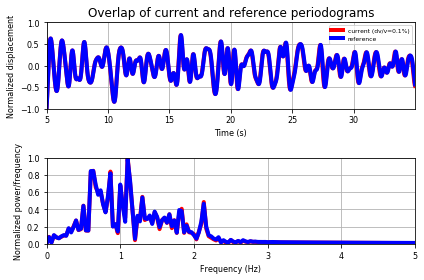

/anaconda3/envs/noisepy/lib/python3.7/site-packages/matplotlib/figure.py:450: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  'figure.' % get_backend())


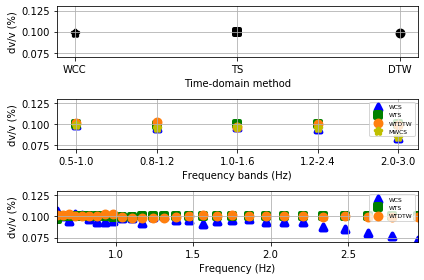

In [ ]:
# plot waveforms & their spectra
para = {'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt, 'ampstr': 'displacement', 'dvov':dvov}
plot_waveform_spectra(ref_homo[itvec], cur_homo[itvec], para)

# plot dv/v estimations
dvv_dict = {'dvv_wcc': dvv_wcc, 'dvv_ts': dvv_ts, 'dvv_dtw': dvv_dtw, 'dvv_mwcs': dvv_mwcs, \
            'dvv_wcs_freqbands': dvv_wcs_freqbands, 'dvv_wts_freqbands': dvv_wts_freqbands, 'dvv_wtdtw_freqbands': dvv_wtdtw_freqbands, \
            'dvv_wcs_allfreqs': dvv_wcs_allfreqs, 'dvv_wts_allfreqs': dvv_wts_allfreqs, 'dvv_wtdtw_allfreqs': dvv_wtdtw_allfreqs }
para = {'freq': [f_min02, f_max02], 'freq_bands':freq_bands, 'freq_vec': freqvec, 'dvov': dvov, 'dvov_range': dvov_range}
plot_dvv_case01(dvv_dict, para)

### 6. Layered half-space setting (example 02)
In this example (see Section 3.2 of our paper), we explore the impact of a more realistic velocity structure (layer over halfspace) on the estimates of dv/v with all methods. We use zero-offset and distant-offset survey geometries to approximate the realistic monitoring observations, autocorrelation and crosscorrelation. In each of them, we perturb the whole space, shallow layer, and deep layer, respectively. The detailed depiction on the experiments are referred to our paper. We validate that the assumption of a linear increase in phase shifts with the time lags for inhomogeneous velocity change; and demonstrate the responses of estimated dv/v to different velocity-change layers. 

#### 6.1. Autocorrelation case - uniform change

In [ ]:
# setup parameters
t0, dt = np.min(t_half_ac_unif), np.diff(t_half_ac_unif).mean() # initial time and time step of simulation data
t_min, t_max = 10., 40. # time duration for computing dv/v
f_min, f_max = 0., 10. # frequency range for which the dv/v is calculated
freq_bands = np.array([[0.6, 1.2], [1.0, 1.5], [1.2,2.5],[2.0,3.5],[3.0,5.0]]) # frequency bands for which the dv/v is calculated

moving_window_length, window_slide_step = 5., 2.5 # moving window lenght and slide step for WCC&MWCS
maxdv, ndv = 0.02, 1000 # maximum dv/v and stretching coefficient number for TS&WTS

#dj, s0, J, sig, wvn = 1/12, -1, -1, False, 'morlet' # default set for wavelet transform analysis

maxLag, b, direction = 50, 1, 1 # maximum search points, maximum perturbation limit, forward direction to accumlate errors for DTW&WTDTW

itvec = np.array(np.arange(np.int((t_min-t0)/dt)+1, np.int((t_max-t0)/dt)+1))
tvec = np.array(t_half_ac_unif[itvec])

dvov, dvov_range = 0.001, [0.0, 0.0012] # true velocity perturbation, dvov limit for visualization
f_min02, f_max02 = 0.5, 5.0 # frequency range of interest for the plots

# compute dv/v
# first group of methods: WCC, TS, DTW
para = {'t': t_half_ac_unif, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

print("Starting using the first group of methods ...")

dvv, error = wcc_dvv(ref_half_ac_unif[itvec], cur_half_ac_unif[itvec], moving_window_length, window_slide_step, para)
dvv_wcc, err_wcc = dvv, error

dvv, error, cc, cdp = ts_dvv(ref_half_ac_unif[itvec], cur_half_ac_unif[itvec], maxdv, ndv, para)
dvv_ts, err_ts, cc_ts, cdp_ts = dvv, error, cc, cdp

dvv, error, dist = dtw_dvv(ref_half_ac_unif[itvec], cur_half_ac_unif[itvec], para, maxLag, b, direction)
dvv_dtw, err_dtw, dist_dtw = dvv, error, dist

print("Fnishing the first group of methods!")

# second group of methods: MWCS, WCS, WTS, WTDTW
nfb = len(freq_bands)
# initializing
dvv_mwcs, dvv_mwcs_err = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wcs_freqbands, err_wcs_freqbands = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wts_freqbands, err_wts_freqbands = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wtdtw_freqbands, err_wtdtw_freqbands = np.zeros([nfb,]), np.zeros([nfb,])

print("Starting using the second group of methods ...")

for ifb in range(nfb):
    fband = freq_bands[ifb]
    print('freqency band (Hz): ',fband)
    
    allfreq = False
    para = {'t': t_half_ac_unif, 'twin': [t_min, t_max],'freq': fband, 'dt': dt}
    dvv, error = mwcs_dvv(ref_half_ac_unif[itvec], cur_half_ac_unif[itvec], moving_window_length, window_slide_step, para, smoothing_half_win=5)
    dvv_mwcs[ifb], dvv_mwcs_err[ifb] = dvv, error
    
    dvv, error = wxs_dvv(ref_half_ac_unif, cur_half_ac_unif,allfreq,para,dj=1/12, s0=-1, J=-1, sig=False, wvn='morlet',unwrapflag=False)
    dvv_wcs_freqbands[ifb], err_wcs_freqbands[ifb] = dvv, error
    
    dvv, error = wts_dvv(ref_half_ac_unif,cur_half_ac_unif,allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_wts_freqbands[ifb], err_wts_freqbands[ifb] = dvv, error
    
    dvv, error = wtdtw_dvv(ref_half_ac_unif,cur_half_ac_unif,allfreq,para,maxLag,b,direction,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_wtdtw_freqbands[ifb], err_wtdtw_freqbands[ifb] = dvv, error
    
print("Fnishing the second group of methods!")

# third group of method
allfreq = True
para = {'t': t_half_ac_unif, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

print("Starting using the third group of methods!")

freqvec, dvv, error = wxs_dvv(ref_half_ac_unif,cur_half_ac_unif,allfreq,para,dj=1/12, s0=-1, J=-1, sig=False, wvn='morlet',unwrapflag=False)
freqvec_wcs, dvv_wcs_allfreqs, err_wcs_allfreqs = freqvec, dvv, error

freqvec, dvv, error = wts_dvv(ref_half_ac_unif,cur_half_ac_unif,allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
freqvec_wts, dvv_wts_allfreqs, err_wts_allfreqs = freqvec, dvv, error

freqvec, dvv, error = wtdtw_dvv(ref_half_ac_unif,cur_half_ac_unif,allfreq,para,maxLag,b,direction,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
freqvec_wtdtw, dvv_wtdtw_allfreqs, err_wtdtw_allfreqs = freqvec, dvv, error

print("Fnishing the third group of methods!")   


Starting using the first group of methods ...
Fnishing the first group of methods!
Starting using the second group of methods ...
freqency band (Hz):  [ 0.6  1.2]
freqency band (Hz):  [ 1.   1.5]
freqency band (Hz):  [ 1.2  2.5]
freqency band (Hz):  [ 2.   3.5]
freqency band (Hz):  [ 3.  5.]
Fnishing the second group of methods!
Starting using the third group of methods!
Fnishing the third group of methods!


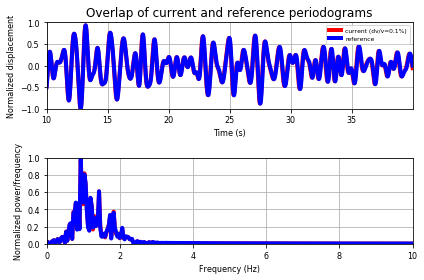

/anaconda3/envs/noisepy/lib/python3.7/site-packages/matplotlib/figure.py:450: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  'figure.' % get_backend())


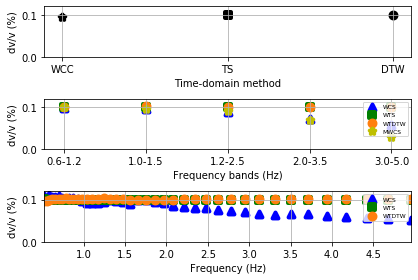

In [ ]:
# plot waveforms & their spectra
para = {'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt, 'ampstr': 'displacement', 'dvov':dvov}
plot_waveform_spectra(ref_half_ac_unif[itvec], cur_half_ac_unif[itvec], para)

# plot dv/v estimations
dvv_dict = {'dvv_wcc': dvv_wcc, 'dvv_ts': dvv_ts, 'dvv_dtw': dvv_dtw, 'dvv_mwcs': dvv_mwcs, \
            'dvv_wcs_freqbands': dvv_wcs_freqbands, 'dvv_wts_freqbands': dvv_wts_freqbands, 'dvv_wtdtw_freqbands': dvv_wtdtw_freqbands, \
            'dvv_wcs_allfreqs': dvv_wcs_allfreqs, 'dvv_wts_allfreqs': dvv_wts_allfreqs, 'dvv_wtdtw_allfreqs': dvv_wtdtw_allfreqs }
para = {'freq': [f_min02, f_max02], 'freq_bands':freq_bands, 'freq_vec': freqvec, 'dvov': dvov, 'dvov_range': dvov_range}
plot_dvv_case01(dvv_dict, para)

#### 6.2. Autocorrelation case  - shallow change

In [ ]:
# setup parameters
t0, dt = np.min(t_half_ac_shall), np.diff(t_half_ac_shall).mean() # initial time and time step of simulation data
t_min, t_max = 10., 40. # time duration for computing dv/v
f_min, f_max = 0., 10. # frequency range for which the dv/v is calculated
freq_bands = np.array([[0.6, 1.2], [1.0, 1.5], [1.2,2.5],[2.0,3.5],[3.0,5.0]]) # frequency bands for which the dv/v is calculated

moving_window_length, window_slide_step = 5., 2.5 # moving window lenght and slide step for WCC&MWCS
maxdv, ndv = 0.02, 1000 # maximum dv/v and stretching coefficient number for TS&WTS

#dj, s0, J, sig, wvn = 1/12, -1, -1, False, 'morlet' # default set for wavelet transform analysis

maxLag, b, direction = 50, 1, 1 # maximum search points, maximum perturbation limit, forward direction to accumlate errors for DTW&WTDTW

itvec = np.array(np.arange(np.int((t_min-t0)/dt)+1, np.int((t_max-t0)/dt)+1))
tvec = np.array(t_half_ac_unif[itvec])

dvov, dvov_range = 0.001, [0.0, 0.0012] # true velocity perturbation, dvov limit for visualization
f_min02, f_max02 = 0.5, 5.0 # frequency range of interest for the plots

# compute dv/v
# first group of methods: WCC, TS, DTW
para = {'t': t_half_ac_shall, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

print("Starting using the first group of methods ...")

dvv, error = wcc_dvv(ref_half_ac_shall[itvec], cur_half_ac_shall[itvec], moving_window_length, window_slide_step, para)
dvv_wcc, err_wcc = dvv, error

dvv, error, cc, cdp = ts_dvv(ref_half_ac_shall[itvec], cur_half_ac_shall[itvec], maxdv, ndv, para)
dvv_ts, err_ts, cc_ts, cdp_ts = dvv, error, cc, cdp

dvv, error, dist = dtw_dvv(ref_half_ac_shall[itvec], cur_half_ac_shall[itvec], para, maxLag, b, direction)
dvv_dtw, err_dtw, dist_dtw = dvv, error, dist

print("Fnishing the first group of methods!")

# second group of methods: MWCS, WCS, WTS, WTDTW
nfb = len(freq_bands)
# initializing
dvv_mwcs, dvv_mwcs_err = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wcs_freqbands, err_wcs_freqbands = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wts_freqbands, err_wts_freqbands = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wtdtw_freqbands, err_wtdtw_freqbands = np.zeros([nfb,]), np.zeros([nfb,])

print("Starting using the second group of methods ...")

for ifb in range(nfb):
    fband = freq_bands[ifb]
    print('freqency band (Hz): ',fband)
    
    allfreq = False
    para = {'t': t_half_ac_unif, 'twin': [t_min, t_max],'freq': fband, 'dt': dt}
    dvv, error = mwcs_dvv(ref_half_ac_shall[itvec], cur_half_ac_shall[itvec], moving_window_length, window_slide_step, para, smoothing_half_win=5)
    dvv_mwcs[ifb], dvv_mwcs_err[ifb] = dvv, error
    
    dvv, error = wxs_dvv(ref_half_ac_shall,cur_half_ac_shall,allfreq,para,dj=1/12, s0=-1, J=-1, sig=False, wvn='morlet',unwrapflag=False)
    dvv_wcs_freqbands[ifb], err_wcs_freqbands[ifb] = dvv, error
    
    dvv, error = wts_dvv(ref_half_ac_shall,cur_half_ac_shall,allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_wts_freqbands[ifb], err_wts_freqbands[ifb] = dvv, error
    
    dvv, error = wtdtw_dvv(ref_half_ac_shall,cur_half_ac_shall,allfreq,para,maxLag,b,direction,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_wtdtw_freqbands[ifb], err_wtdtw_freqbands[ifb] = dvv, error
    
print("Fnishing the second group of methods!")

# third group of method
allfreq = True
para = {'t': t_half_ac_unif, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

print("Starting using the third group of methods!")

freqvec, dvv, error = wxs_dvv(ref_half_ac_shall,cur_half_ac_shall,allfreq,para,dj=1/12, s0=-1, J=-1, sig=False, wvn='morlet',unwrapflag=False)
freqvec_wcs, dvv_wcs_allfreqs, err_wcs_allfreqs = freqvec, dvv, error

freqvec, dvv, error = wts_dvv(ref_half_ac_shall,cur_half_ac_shall,allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
freqvec_wts, dvv_wts_allfreqs, err_wts_allfreqs = freqvec, dvv, error

freqvec, dvv, error = wtdtw_dvv(ref_half_ac_shall,cur_half_ac_shall,allfreq,para,maxLag,b,direction,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
freqvec_wtdtw, dvv_wtdtw_allfreqs, err_wtdtw_allfreqs = freqvec, dvv, error

print("Fnishing the third group of methods!")   


Starting using the first group of methods ...
Fnishing the first group of methods!
Starting using the second group of methods ...
freqency band (Hz):  [ 0.6  1.2]
freqency band (Hz):  [ 1.   1.5]
freqency band (Hz):  [ 1.2  2.5]
freqency band (Hz):  [ 2.   3.5]
freqency band (Hz):  [ 3.  5.]
Fnishing the second group of methods!
Starting using the third group of methods!
Fnishing the third group of methods!


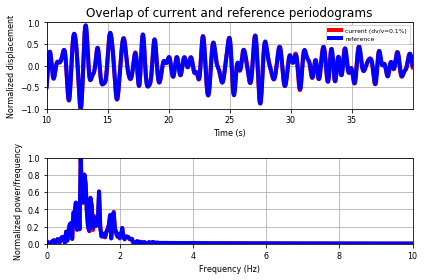

/anaconda3/envs/noisepy/lib/python3.7/site-packages/matplotlib/figure.py:450: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  'figure.' % get_backend())


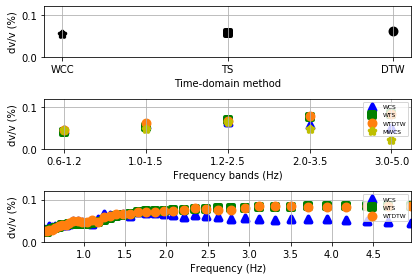

In [ ]:
# plot waveforms & their spectra
para = {'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt, 'ampstr': 'displacement', 'dvov':dvov}
plot_waveform_spectra(ref_half_ac_shall[itvec], cur_half_ac_shall[itvec], para)

# plot dv/v estimations
dvv_dict = {'dvv_wcc': dvv_wcc, 'dvv_ts': dvv_ts, 'dvv_dtw': dvv_dtw, 'dvv_mwcs': dvv_mwcs, \
            'dvv_wcs_freqbands': dvv_wcs_freqbands, 'dvv_wts_freqbands': dvv_wts_freqbands, 'dvv_wtdtw_freqbands': dvv_wtdtw_freqbands, \
            'dvv_wcs_allfreqs': dvv_wcs_allfreqs, 'dvv_wts_allfreqs': dvv_wts_allfreqs, 'dvv_wtdtw_allfreqs': dvv_wtdtw_allfreqs }
para = {'freq': [f_min02, f_max02], 'freq_bands':freq_bands, 'freq_vec': freqvec, 'dvov': dvov, 'dvov_range': dvov_range}
plot_dvv_case01(dvv_dict, para)

#### 6.3. Autocorrelation case  - deep change

In [ ]:
# setup parameters
t0, dt = np.min(t_half_ac_deep), np.diff(t_half_ac_deep).mean() # initial time and time step of simulation data
t_min, t_max = 10., 40. # time duration for computing dv/v
f_min, f_max = 0., 10. # frequency range for which the dv/v is calculated
freq_bands = np.array([[0.6, 1.2], [1.0, 1.5], [1.2,2.5],[2.0,3.5],[3.0,5.0]]) # frequency bands for which the dv/v is calculated

moving_window_length, window_slide_step = 5., 2.5 # moving window lenght and slide step for WCC&MWCS
maxdv, ndv = 0.02, 1000 # maximum dv/v and stretching coefficient number for TS&WTS

#dj, s0, J, sig, wvn = 1/12, -1, -1, False, 'morlet' # default set for wavelet transform analysis

maxLag, b, direction = 50, 1, 1 # maximum search points, maximum perturbation limit, forward direction to accumlate errors for DTW&WTDTW

itvec = np.array(np.arange(np.int((t_min-t0)/dt)+1, np.int((t_max-t0)/dt)+1))
tvec = np.array(t_half_ac_unif[itvec])

dvov, dvov_range = 0.001, [0.0, 0.0012] # true velocity perturbation, dvov limit for visualization
f_min02, f_max02 = 0.5, 5.0 # frequency range of interest for the plots

# compute dv/v
# first group of methods: WCC, TS, DTW
para = {'t': t_half_ac_shall, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

print("Starting using the first group of methods ...")

dvv, error = wcc_dvv(ref_half_ac_deep[itvec], cur_half_ac_deep[itvec], moving_window_length, window_slide_step, para)
dvv_wcc, err_wcc = dvv, error

dvv, error, cc, cdp = ts_dvv(ref_half_ac_deep[itvec], cur_half_ac_deep[itvec], maxdv, ndv, para)
dvv_ts, err_ts, cc_ts, cdp_ts = dvv, error, cc, cdp

dvv, error, dist = dtw_dvv(ref_half_ac_deep[itvec], cur_half_ac_deep[itvec], para, maxLag, b, direction)
dvv_dtw, err_dtw, dist_dtw = dvv, error, dist

print("Fnishing the first group of methods!")

# second group of methods: MWCS, WCS, WTS, WTDTW
nfb = len(freq_bands)
# initializing
dvv_mwcs, dvv_mwcs_err = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wcs_freqbands, err_wcs_freqbands = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wts_freqbands, err_wts_freqbands = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wtdtw_freqbands, err_wtdtw_freqbands = np.zeros([nfb,]), np.zeros([nfb,])

print("Starting using the second group of methods ...")

for ifb in range(nfb):
    fband = freq_bands[ifb]
    print('freqency band (Hz): ',fband)
    
    allfreq = False
    para = {'t': t_half_ac_unif, 'twin': [t_min, t_max],'freq': fband, 'dt': dt}
    dvv, error = mwcs_dvv(ref_half_ac_deep[itvec],cur_half_ac_deep[itvec], moving_window_length, window_slide_step, para, smoothing_half_win=5)
    dvv_mwcs[ifb], dvv_mwcs_err[ifb] = dvv, error
    
    dvv, error = wxs_dvv(ref_half_ac_deep,cur_half_ac_deep,allfreq,para,dj=1/12, s0=-1, J=-1, sig=False, wvn='morlet',unwrapflag=False)
    dvv_wcs_freqbands[ifb], err_wcs_freqbands[ifb] = dvv, error
    
    dvv, error = wts_dvv(ref_half_ac_deep,cur_half_ac_deep,allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_wts_freqbands[ifb], err_wts_freqbands[ifb] = dvv, error
    
    dvv, error = wtdtw_dvv(ref_half_ac_deep,cur_half_ac_deep,allfreq,para,maxLag,b,direction,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_wtdtw_freqbands[ifb], err_wtdtw_freqbands[ifb] = dvv, error
    
print("Fnishing the second group of methods!")

# third group of method
allfreq = True
para = {'t': t_half_ac_unif, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

print("Starting using the third group of methods!")

freqvec, dvv, error = wxs_dvv(ref_half_ac_deep,cur_half_ac_deep,allfreq,para,dj=1/12, s0=-1, J=-1, sig=False, wvn='morlet',unwrapflag=False)
freqvec_wcs, dvv_wcs_allfreqs, err_wcs_allfreqs = freqvec, dvv, error

freqvec, dvv, error = wts_dvv(ref_half_ac_deep,cur_half_ac_deep,allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
freqvec_wts, dvv_wts_allfreqs, err_wts_allfreqs = freqvec, dvv, error

freqvec, dvv, error = wtdtw_dvv(ref_half_ac_deep,cur_half_ac_deep,allfreq,para,maxLag,b,direction,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
freqvec_wtdtw, dvv_wtdtw_allfreqs, err_wtdtw_allfreqs = freqvec, dvv, error

print("Fnishing the third group of methods!")   


Starting using the first group of methods ...
Fnishing the first group of methods!
Starting using the second group of methods ...
freqency band (Hz):  [ 0.6  1.2]
freqency band (Hz):  [ 1.   1.5]
freqency band (Hz):  [ 1.2  2.5]
freqency band (Hz):  [ 2.   3.5]
freqency band (Hz):  [ 3.  5.]
Fnishing the second group of methods!
Starting using the third group of methods!
Fnishing the third group of methods!


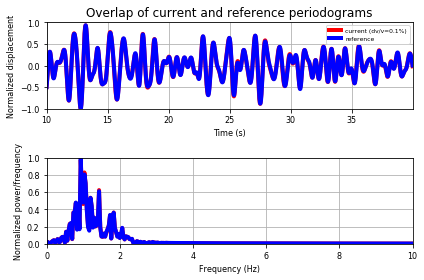

/anaconda3/envs/noisepy/lib/python3.7/site-packages/matplotlib/figure.py:450: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  'figure.' % get_backend())


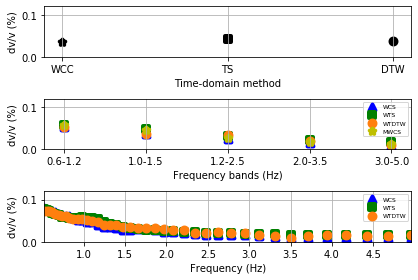

In [ ]:
# plot waveforms & their spectra
para = {'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt, 'ampstr': 'displacement', 'dvov':dvov}
plot_waveform_spectra(ref_half_ac_deep[itvec], cur_half_ac_deep[itvec], para)

# plot dv/v estimations
dvv_dict = {'dvv_wcc': dvv_wcc, 'dvv_ts': dvv_ts, 'dvv_dtw': dvv_dtw, 'dvv_mwcs': dvv_mwcs, \
            'dvv_wcs_freqbands': dvv_wcs_freqbands, 'dvv_wts_freqbands': dvv_wts_freqbands, 'dvv_wtdtw_freqbands': dvv_wtdtw_freqbands, \
            'dvv_wcs_allfreqs': dvv_wcs_allfreqs, 'dvv_wts_allfreqs': dvv_wts_allfreqs, 'dvv_wtdtw_allfreqs': dvv_wtdtw_allfreqs }
para = {'freq': [f_min02, f_max02], 'freq_bands':freq_bands, 'freq_vec': freqvec, 'dvov': dvov, 'dvov_range': dvov_range}
plot_dvv_case01(dvv_dict, para)

#### 6.4. Crosscorrelation case  -  uniform change

In [ ]:
# setup parameters
t0, dt = np.min(t_half_cc_unif), np.diff(t_half_cc_unif).mean() # initial time and time step of simulation data
t_min, t_max = 180, 240 # time duration for computing dv/v
f_min, f_max = 0., 1.5 # frequency range for which the dv/v is calculated
freq_bands = np.array([[0.1, 0.3], [0.2, 0.4], [0.3,0.6], [0.5,0.8], [0.6,1.0]]) # frequency bands for which the dv/v is calculated

moving_window_length, window_slide_step = 5., 2.5 # moving window lenght and slide step for WCC&MWCS
maxdv, ndv = 0.02, 1000 # maximum dv/v and stretching coefficient number for TS&WTS

#dj, s0, J, sig, wvn = 1/12, -1, -1, False, 'morlet' # default set for wavelet transform analysis

maxLag, b, direction = 50, 1, 1 # maximum search points, maximum perturbation limit, forward direction to accumlate errors for DTW&WTDTW

itvec = np.array(np.arange(np.int((t_min-t0)/dt)+1, np.int((t_max-t0)/dt)+1))
tvec = np.array(t_half_cc_unif[itvec])

dvov, dvov_range = 0.001, [0.0, 0.0012] # true velocity perturbation, dvov limit for visualization
f_min02, f_max02 = 0.1, 1.0 # frequency range of interest for the plots

# compute dv/v
# first group of methods: WCC, TS, DTW
para = {'t': t_half_cc_unif, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

print("Starting using the first group of methods ...")

dvv, error = wcc_dvv(ref_half_cc_unif[itvec], cur_half_cc_unif[itvec], moving_window_length, window_slide_step, para)
dvv_wcc, err_wcc = dvv, error

dvv, error, cc, cdp = ts_dvv(ref_half_cc_unif[itvec], cur_half_cc_unif[itvec], maxdv, ndv, para)
dvv_ts, err_ts, cc_ts, cdp_ts = dvv, error, cc, cdp

dvv, error, dist = dtw_dvv(ref_half_cc_unif[itvec], cur_half_cc_unif[itvec], para, maxLag, b, direction)
dvv_dtw, err_dtw, dist_dtw = dvv, error, dist

print("Fnishing the first group of methods!")

# second group of methods: MWCS, WCS, WTS, WTDTW
nfb = len(freq_bands)
# initializing
dvv_mwcs, dvv_mwcs_err = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wcs_freqbands, err_wcs_freqbands = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wts_freqbands, err_wts_freqbands = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wtdtw_freqbands, err_wtdtw_freqbands = np.zeros([nfb,]), np.zeros([nfb,])

print("Starting using the second group of methods ...")
for ifb in range(nfb):
    fband = freq_bands[ifb]
    print('freqency band (Hz): ',fband)
    
    allfreq = False
    para = {'t': t_half_cc_unif, 'twin': [t_min, t_max],'freq': fband, 'dt': dt}
    dvv, error = mwcs_dvv(ref_half_cc_unif[itvec], cur_half_cc_unif[itvec], moving_window_length, window_slide_step, para, smoothing_half_win=5)
    dvv_mwcs[ifb], dvv_mwcs_err[ifb] = dvv, error
    
    dvv, error = wxs_dvv(ref_half_cc_unif, cur_half_cc_unif,allfreq,para,dj=1/12, s0=-1, J=-1, sig=False, wvn='morlet',unwrapflag=False)
    dvv_wcs_freqbands[ifb], err_wcs_freqbands[ifb] = dvv, error
    
    dvv, error = wts_dvv(ref_half_cc_unif,cur_half_cc_unif,allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_wts_freqbands[ifb], err_wts_freqbands[ifb] = dvv, error
    
    dvv, error = wtdtw_dvv(ref_half_cc_unif,cur_half_cc_unif,allfreq,para,maxLag,b,direction,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_wtdtw_freqbands[ifb], err_wtdtw_freqbands[ifb] = dvv, error
    
print("Fnishing the second group of methods!")

# third group of method
allfreq = True
para = {'t': t_half_cc_unif, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

print("Starting using the third group of methods!")

freqvec, dvv, error = wxs_dvv(ref_half_cc_unif,cur_half_cc_unif,allfreq,para,dj=1/12, s0=-1, J=-1, sig=False, wvn='morlet',unwrapflag=False)
freqvec_wcs, dvv_wcs_allfreqs, err_wcs_allfreqs = freqvec, dvv, error

freqvec, dvv, error = wts_dvv(ref_half_cc_unif,cur_half_cc_unif,allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
freqvec_wts, dvv_wts_allfreqs, err_wts_allfreqs = freqvec, dvv, error

freqvec, dvv, error = wtdtw_dvv(ref_half_cc_unif,cur_half_cc_unif,allfreq,para,maxLag,b,direction,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
freqvec_wtdtw, dvv_wtdtw_allfreqs, err_wtdtw_allfreqs = freqvec, dvv, error

print("Fnishing the third group of methods!")   


Starting using the first group of methods ...
Fnishing the first group of methods!
Starting using the second group of methods ...
freqency band (Hz):  [ 0.1  0.3]


/Users/jackie_yuan/Documents/software/NoisePy/Jupyter_notebook/dvv_module.py:1138: RuntimeWarning: divide by zero encountered in true_divide
  WCT = np.abs(S12) ** 2 / (S1 * S2)


freqency band (Hz):  [ 0.2  0.4]
freqency band (Hz):  [ 0.3  0.6]
freqency band (Hz):  [ 0.5  0.8]
freqency band (Hz):  [ 0.6  1. ]
Fnishing the second group of methods!
Starting using the third group of methods!
Fnishing the third group of methods!


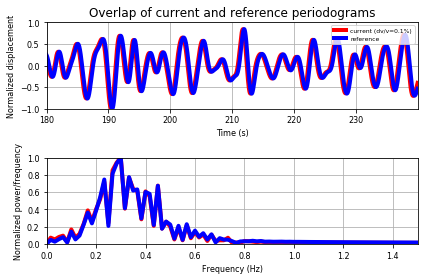

/anaconda3/envs/noisepy/lib/python3.7/site-packages/matplotlib/figure.py:450: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  'figure.' % get_backend())


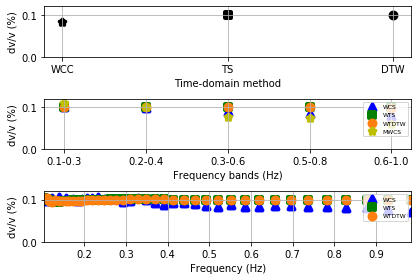

In [ ]:
# plot waveforms & their spectra
para = {'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt, 'ampstr': 'displacement', 'dvov':dvov}
plot_waveform_spectra(ref_half_cc_unif[itvec], cur_half_cc_unif[itvec], para)

# plot dv/v estimations
dvv_dict = {'dvv_wcc': dvv_wcc, 'dvv_ts': dvv_ts, 'dvv_dtw': dvv_dtw, 'dvv_mwcs': dvv_mwcs, \
            'dvv_wcs_freqbands': dvv_wcs_freqbands, 'dvv_wts_freqbands': dvv_wts_freqbands, 'dvv_wtdtw_freqbands': dvv_wtdtw_freqbands, \
            'dvv_wcs_allfreqs': dvv_wcs_allfreqs, 'dvv_wts_allfreqs': dvv_wts_allfreqs, 'dvv_wtdtw_allfreqs': dvv_wtdtw_allfreqs }
para = {'freq': [f_min02, f_max02], 'freq_bands':freq_bands, 'freq_vec': freqvec, 'dvov': dvov, 'dvov_range': dvov_range}
plot_dvv_case01(dvv_dict, para)

#### 6.5. Crosscorrelation case  - shallow change

In [ ]:
# setup parameters
t0, dt = np.min(t_half_cc_shall), np.diff(t_half_cc_shall).mean() # initial time and time step of simulation data
t_min, t_max = 180, 240 # time duration for computing dv/v
f_min, f_max = 0., 1.5 # frequency range for which the dv/v is calculated
freq_bands = np.array([[0.1, 0.3], [0.2, 0.4], [0.3,0.6], [0.5,0.8], [0.6,1.0]]) # frequency bands for which the dv/v is calculated

moving_window_length, window_slide_step = 5., 2.5 # moving window lenght and slide step for WCC&MWCS
maxdv, ndv = 0.02, 1000 # maximum dv/v and stretching coefficient number for TS&WTS

#dj, s0, J, sig, wvn = 1/12, -1, -1, False, 'morlet' # default set for wavelet transform analysis

maxLag, b, direction = 50, 1, 1 # maximum search points, maximum perturbation limit, forward direction to accumlate errors for DTW&WTDTW

itvec = np.array(np.arange(np.int((t_min-t0)/dt)+1, np.int((t_max-t0)/dt)+1))
tvec = np.array(t_half_cc_shall[itvec])

dvov, dvov_range = 0.001, [0.0, 0.0012] # true velocity perturbation, dvov limit for visualization
f_min02, f_max02 = 0.1, 1.0 # frequency range of interest for the plots

# compute dv/v
# first group of methods: WCC, TS, DTW
para = {'t': t_half_cc_shall, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

print("Starting using the first group of methods ...")

dvv, error = wcc_dvv(ref_half_cc_shall[itvec], cur_half_cc_shall[itvec], moving_window_length, window_slide_step, para)
dvv_wcc, err_wcc = dvv, error

dvv, error, cc, cdp = ts_dvv(ref_half_cc_shall[itvec], cur_half_cc_shall[itvec], maxdv, ndv, para)
dvv_ts, err_ts, cc_ts, cdp_ts = dvv, error, cc, cdp

dvv, error, dist = dtw_dvv(ref_half_cc_shall[itvec], cur_half_cc_shall[itvec], para, maxLag, b, direction)
dvv_dtw, err_dtw, dist_dtw = dvv, error, dist

print("Fnishing the first group of methods!")

# second group of methods: MWCS, WCS, WTS, WTDTW
nfb = len(freq_bands)
# initializing
dvv_mwcs, dvv_mwcs_err = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wcs_freqbands, err_wcs_freqbands = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wts_freqbands, err_wts_freqbands = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wtdtw_freqbands, err_wtdtw_freqbands = np.zeros([nfb,]), np.zeros([nfb,])

print("Starting using the second group of methods ...")
for ifb in range(nfb):
    fband = freq_bands[ifb]
    print('freqency band (Hz): ',fband)
    
    allfreq = False
    para = {'t': t_half_cc_shall, 'twin': [t_min, t_max],'freq': fband, 'dt': dt}
    dvv, error = mwcs_dvv(ref_half_cc_shall[itvec], cur_half_cc_shall[itvec], moving_window_length, window_slide_step, para, smoothing_half_win=5)
    dvv_mwcs[ifb], dvv_mwcs_err[ifb] = dvv, error
    
    dvv, error = wxs_dvv(ref_half_cc_shall, cur_half_cc_shall,allfreq,para,dj=1/12, s0=-1, J=-1, sig=False, wvn='morlet',unwrapflag=False)
    dvv_wcs_freqbands[ifb], err_wcs_freqbands[ifb] = dvv, error
    
    dvv, error = wts_dvv(ref_half_cc_shall,cur_half_cc_shall,allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_wts_freqbands[ifb], err_wts_freqbands[ifb] = dvv, error
    
    dvv, error = wtdtw_dvv(ref_half_cc_shall,cur_half_cc_shall,allfreq,para,maxLag,b,direction,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_wtdtw_freqbands[ifb], err_wtdtw_freqbands[ifb] = dvv, error
    
print("Fnishing the second group of methods!")

# third group of method
allfreq = True
para = {'t': t_half_cc_shall, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

print("Starting using the third group of methods!")

freqvec, dvv, error = wxs_dvv(ref_half_cc_shall,cur_half_cc_shall,allfreq,para,dj=1/12, s0=-1, J=-1, sig=False, wvn='morlet',unwrapflag=False)
freqvec_wcs, dvv_wcs_allfreqs, err_wcs_allfreqs = freqvec, dvv, error

freqvec, dvv, error = wts_dvv(ref_half_cc_shall,cur_half_cc_shall,allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
freqvec_wts, dvv_wts_allfreqs, err_wts_allfreqs = freqvec, dvv, error

freqvec, dvv, error = wtdtw_dvv(ref_half_cc_shall,cur_half_cc_shall,allfreq,para,maxLag,b,direction,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
freqvec_wtdtw, dvv_wtdtw_allfreqs, err_wtdtw_allfreqs = freqvec, dvv, error

print("Fnishing the third group of methods!")     

Starting using the first group of methods ...
Fnishing the first group of methods!
Starting using the second group of methods ...
freqency band (Hz):  [ 0.1  0.3]


/Users/jackie_yuan/Documents/software/NoisePy/Jupyter_notebook/dvv_module.py:1138: RuntimeWarning: divide by zero encountered in true_divide
  WCT = np.abs(S12) ** 2 / (S1 * S2)


freqency band (Hz):  [ 0.2  0.4]
freqency band (Hz):  [ 0.3  0.6]
freqency band (Hz):  [ 0.5  0.8]
freqency band (Hz):  [ 0.6  1. ]
Fnishing the second group of methods!
Starting using the third group of methods!
Fnishing the third group of methods!


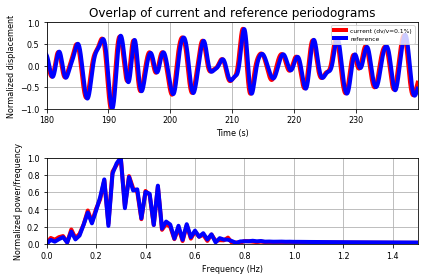

/anaconda3/envs/noisepy/lib/python3.7/site-packages/matplotlib/figure.py:450: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  'figure.' % get_backend())


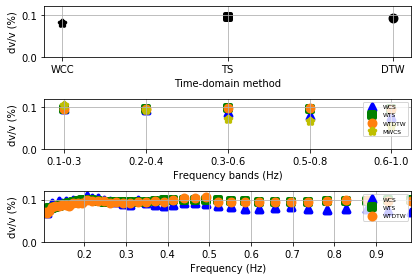

In [ ]:
# plot waveforms & their spectra
para = {'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt, 'ampstr': 'displacement', 'dvov':dvov}
plot_waveform_spectra(ref_half_cc_shall[itvec], cur_half_cc_shall[itvec], para)

# plot dv/v estimations
dvv_dict = {'dvv_wcc': dvv_wcc, 'dvv_ts': dvv_ts, 'dvv_dtw': dvv_dtw, 'dvv_mwcs': dvv_mwcs, \
            'dvv_wcs_freqbands': dvv_wcs_freqbands, 'dvv_wts_freqbands': dvv_wts_freqbands, 'dvv_wtdtw_freqbands': dvv_wtdtw_freqbands, \
            'dvv_wcs_allfreqs': dvv_wcs_allfreqs, 'dvv_wts_allfreqs': dvv_wts_allfreqs, 'dvv_wtdtw_allfreqs': dvv_wtdtw_allfreqs }
para = {'freq': [f_min02, f_max02], 'freq_bands':freq_bands, 'freq_vec': freqvec, 'dvov': dvov, 'dvov_range': dvov_range}
plot_dvv_case01(dvv_dict, para)

#### 6.6. Crosscorrelation case  -  deep change

In [ ]:
# setup parameters
t0, dt = np.min(t_half_cc_deep), np.diff(t_half_cc_deep).mean() # initial time and time step of simulation data
t_min, t_max = 180, 240 # time duration for computing dv/v
f_min, f_max = 0., 1.5 # frequency range for which the dv/v is calculated
freq_bands = np.array([[0.1, 0.3], [0.2, 0.4], [0.3,0.6], [0.5,0.8], [0.6,1.0]]) # frequency bands for which the dv/v is calculated

moving_window_length, window_slide_step = 5., 2.5 # moving window lenght and slide step for WCC&MWCS
maxdv, ndv = 0.02, 1000 # maximum dv/v and stretching coefficient number for TS&WTS

#dj, s0, J, sig, wvn = 1/12, -1, -1, False, 'morlet' # default set for wavelet transform analysis

maxLag, b, direction = 50, 1, 1 # maximum search points, maximum perturbation limit, forward direction to accumlate errors for DTW&WTDTW

itvec = np.array(np.arange(np.int((t_min-t0)/dt)+1, np.int((t_max-t0)/dt)+1))
tvec = np.array(t_half_cc_deep[itvec])

dvov, dvov_range = 0.001, [0.0, 0.0012] # true velocity perturbation, dvov limit for visualization
f_min02, f_max02 = 0.1, 1.0 # frequency range of interest for the plots

# compute dv/v
# first group of methods: WCC, TS, DTW
para = {'t': t_half_cc_deep, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

print("Starting using the first group of methods ...")

dvv, error = wcc_dvv(ref_half_cc_deep[itvec], cur_half_cc_deep[itvec], moving_window_length, window_slide_step, para)
dvv_wcc, err_wcc = dvv, error

dvv, error, cc, cdp = ts_dvv(ref_half_cc_deep[itvec], cur_half_cc_deep[itvec], maxdv, ndv, para)
dvv_ts, err_ts, cc_ts, cdp_ts = dvv, error, cc, cdp

dvv, error, dist = dtw_dvv(ref_half_cc_deep[itvec], cur_half_cc_deep[itvec], para, maxLag, b, direction)
dvv_dtw, err_dtw, dist_dtw = dvv, error, dist

print("Fnishing the first group of methods!")

# second group of methods: MWCS, WCS, WTS, WTDTW
nfb = len(freq_bands)
# initializing
dvv_mwcs, dvv_mwcs_err = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wcs_freqbands, err_wcs_freqbands = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wts_freqbands, err_wts_freqbands = np.zeros([nfb,]), np.zeros([nfb,])
dvv_wtdtw_freqbands, err_wtdtw_freqbands = np.zeros([nfb,]), np.zeros([nfb,])

print("Starting using the second group of methods ...")
for ifb in range(nfb):
    fband = freq_bands[ifb]
    print('freqency band (Hz): ',fband)
    
    allfreq = False
    para = {'t': t_half_cc_deep, 'twin': [t_min, t_max],'freq': fband, 'dt': dt}
    dvv, error = mwcs_dvv(ref_half_cc_deep[itvec], cur_half_cc_deep[itvec], moving_window_length, window_slide_step, para, smoothing_half_win=5)
    dvv_mwcs[ifb], dvv_mwcs_err[ifb] = dvv, error
    
    dvv, error = wxs_dvv(ref_half_cc_deep, cur_half_cc_deep,allfreq,para,dj=1/12, s0=-1, J=-1, sig=False, wvn='morlet',unwrapflag=False)
    dvv_wcs_freqbands[ifb], err_wcs_freqbands[ifb] = dvv, error
    
    dvv, error = wts_dvv(ref_half_cc_deep,cur_half_cc_deep,allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_wts_freqbands[ifb], err_wts_freqbands[ifb] = dvv, error
    
    dvv, error = wtdtw_dvv(ref_half_cc_deep,cur_half_cc_deep,allfreq,para,maxLag,b,direction,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_wtdtw_freqbands[ifb], err_wtdtw_freqbands[ifb] = dvv, error
    
print("Fnishing the second group of methods!")

# third group of method
allfreq = True
para = {'t': t_half_cc_shall, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

print("Starting using the third group of methods!")

freqvec, dvv, error = wxs_dvv(ref_half_cc_deep,cur_half_cc_deep,allfreq,para,dj=1/12, s0=-1, J=-1, sig=False, wvn='morlet',unwrapflag=False)
freqvec_wcs, dvv_wcs_allfreqs, err_wcs_allfreqs = freqvec, dvv, error

freqvec, dvv, error = wts_dvv(ref_half_cc_deep,cur_half_cc_deep,allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
freqvec_wts, dvv_wts_allfreqs, err_wts_allfreqs = freqvec, dvv, error

freqvec, dvv, error = wtdtw_dvv(ref_half_cc_deep,cur_half_cc_deep,allfreq,para,maxLag,b,direction,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
freqvec_wtdtw, dvv_wtdtw_allfreqs, err_wtdtw_allfreqs = freqvec, dvv, error

print("Fnishing the third group of methods!")     

Starting using the first group of methods ...
Fnishing the first group of methods!
Starting using the second group of methods ...
freqency band (Hz):  [ 0.1  0.3]


/Users/jackie_yuan/Documents/software/NoisePy/Jupyter_notebook/dvv_module.py:1138: RuntimeWarning: divide by zero encountered in true_divide
  WCT = np.abs(S12) ** 2 / (S1 * S2)


freqency band (Hz):  [ 0.2  0.4]
freqency band (Hz):  [ 0.3  0.6]
freqency band (Hz):  [ 0.5  0.8]
freqency band (Hz):  [ 0.6  1. ]
Fnishing the second group of methods!
Starting using the third group of methods!
Fnishing the third group of methods!


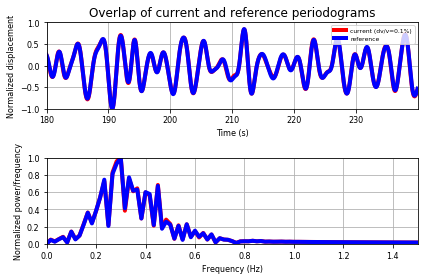

/anaconda3/envs/noisepy/lib/python3.7/site-packages/matplotlib/figure.py:450: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  'figure.' % get_backend())


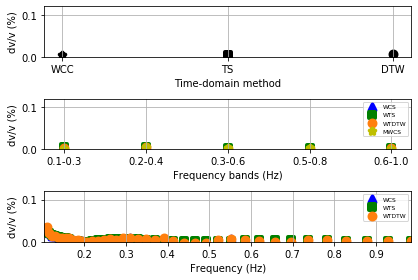

In [ ]:
# plot waveforms & their spectra
para = {'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt, 'ampstr': 'displacement', 'dvov':dvov}
plot_waveform_spectra(ref_half_cc_deep[itvec], cur_half_cc_deep[itvec], para)

# plot dv/v estimations
dvv_dict = {'dvv_wcc': dvv_wcc, 'dvv_ts': dvv_ts, 'dvv_dtw': dvv_dtw, 'dvv_mwcs': dvv_mwcs, \
            'dvv_wcs_freqbands': dvv_wcs_freqbands, 'dvv_wts_freqbands': dvv_wts_freqbands, 'dvv_wtdtw_freqbands': dvv_wtdtw_freqbands, \
            'dvv_wcs_allfreqs': dvv_wcs_allfreqs, 'dvv_wts_allfreqs': dvv_wts_allfreqs, 'dvv_wtdtw_allfreqs': dvv_wtdtw_allfreqs }
para = {'freq': [f_min02, f_max02], 'freq_bands':freq_bands, 'freq_vec': freqvec, 'dvov': dvov, 'dvov_range': dvov_range}
plot_dvv_case01(dvv_dict, para)

### 7. Depth sensitivity to velocity change  (example 03)
In this example (see Section 4 of our paper), we aim to systematically explore this effect in a similar fashion as Obermann et al. (2013). We perturb the velocity of a thin layer that we “slide” from top to bottom with a +0.1% perturbation of the background velocities. Again, see more details about the setup of the experiments in our paper. We emphasize that the depth of velocity perturbation greatly impacts the shape of the spectrum of dv/v, which may help us to constrain and infer the depth of velocity changes.

#### 7.1 Autocorrelation case

In [ ]:
# only using WTS
# setup parameters
t0, dt = np.min(t_depth_ac), np.diff(t_depth_ac).mean() # initial time and time step of simulation data
t_min, t_max = 2.5, 6.5 # time duration for computing dv/v
f_min, f_max = 0., 35. # frequency range for which the dv/v is calculated

maxdv, ndv = 0.02, 1000 # maximum dv/v and stretching coefficient number for TS&WTS

#dj, s0, J, sig, wvn = 1/12, -1, -1, False, 'morlet' # default set for wavelet transform analysis

itvec = np.array(np.arange(np.int((t_min-t0)/dt)+1, np.int((t_max-t0)/dt)+1))
tvec = np.array(t_depth_ac[itvec])

dvov, dvov_range = 0.001, [-0.0001, 0.0012] # true velocity perturbation, dvov limit for visualization
f_min02, f_max02 = 0.5, 30.0 # frequency range of interest for the plots

# compute dv/v
ldep, ddep, rdep, dz = 0, 5, 50, 0.02
ndep = np.int((rdep-ldep)/ddep)

allfreq = True
para = {'t': t_depth_ac, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

count=0
dvv_allfreqs, err_allfreqs = [], []
# loop depth
for idep in np.arange(ldep, rdep, ddep):
    print("Working on depth: %1.1f(km)"%(idep*dz))

    freqvec, dvv, error = wts_dvv(ref_depth_ac, cur_depth_ac[:,count],allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_allfreqs.append(dvv)
    err_allfreqs.append(error)

    count+=1

# reshape lists to 2d array
dvv_wts_allfreqs = np.reshape(np.asarray(dvv_allfreqs), (count, len(freqvec)))
err_wts_allfreqs = np.reshape(np.asarray(err_allfreqs), (count, len(freqvec)))

Working on depth: 0.0(km)
Working on depth: 0.1(km)
Working on depth: 0.2(km)
Working on depth: 0.3(km)
Working on depth: 0.4(km)
Working on depth: 0.5(km)
Working on depth: 0.6(km)
Working on depth: 0.7(km)
Working on depth: 0.8(km)
Working on depth: 0.9(km)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

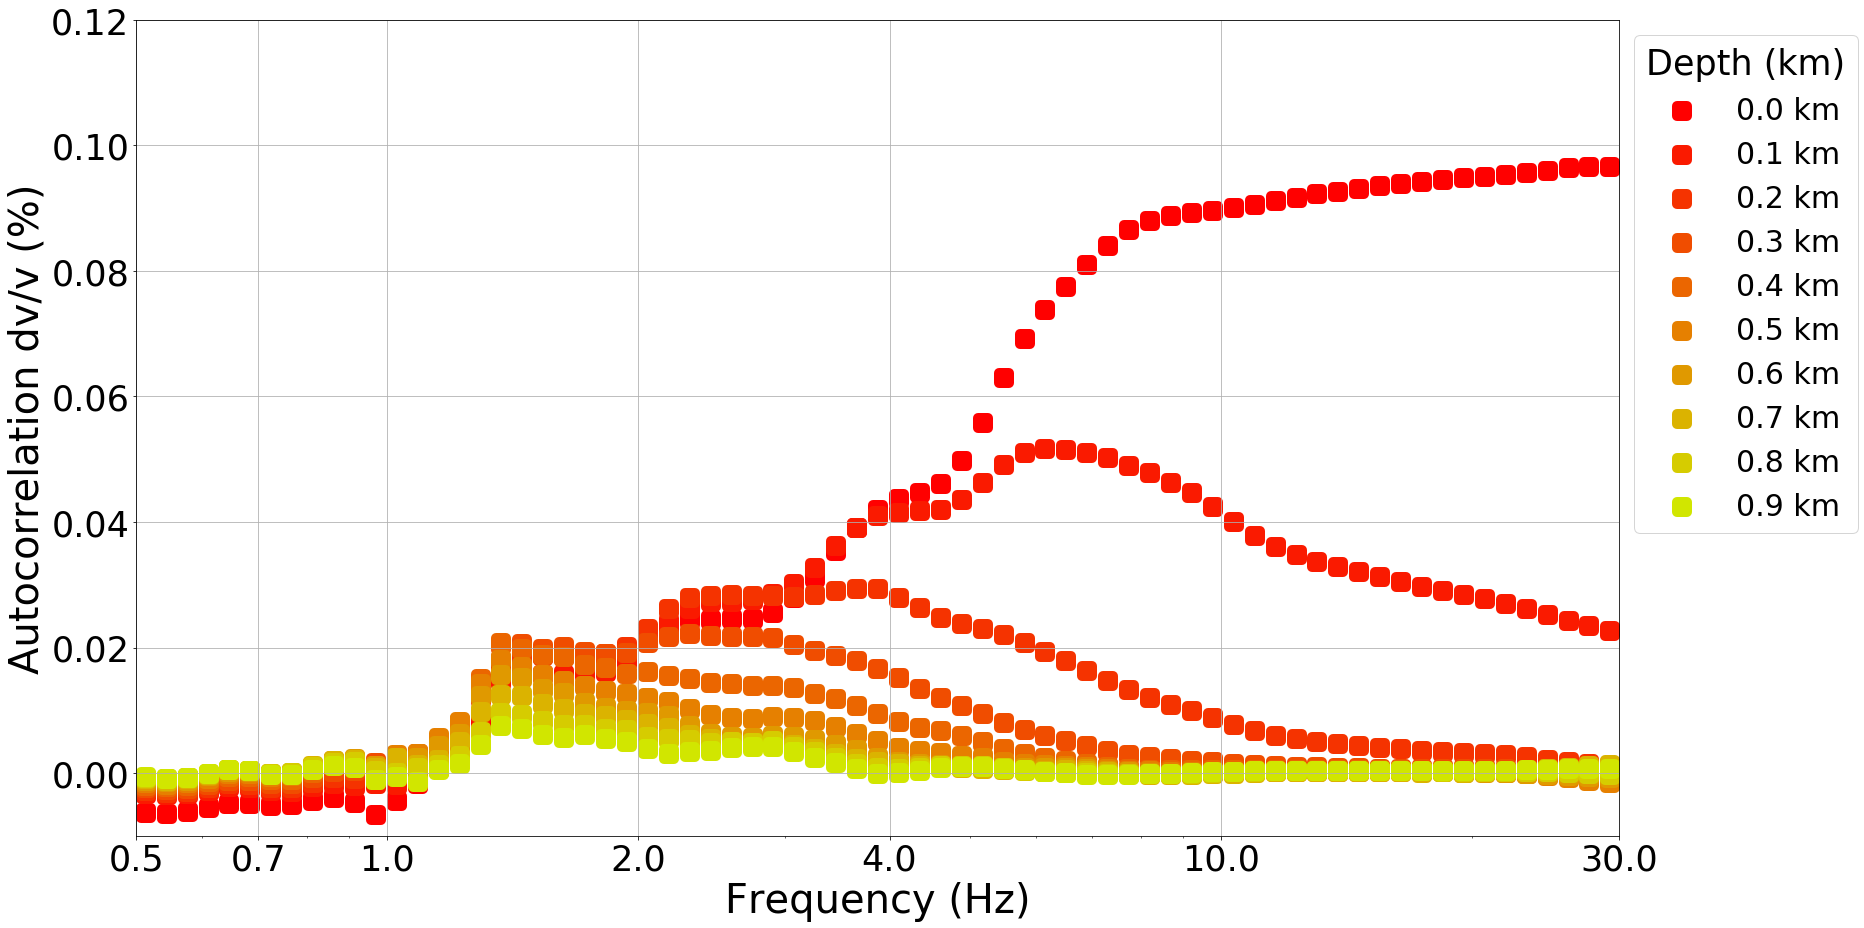

In [ ]:
# plot dv/v estimations
sflag = 'ac'
dvv_dict = {'dvv_wts_allfreqs': dvv_wts_allfreqs}
para = {'freq': [f_min02, f_max02], 'freq_vec': freqvec, 'dvov': dvov, 'dvov_range': dvov_range, 'sdep': ddep*dz, 'sflag': sflag}

plot_dvv_case02(dvv_dict, para)

#### 7.2 Crosscorrelation case

In [ ]:
# only using WTS
# setup parameters
t0, dt = np.min(t_depth_cc), np.diff(t_depth_cc).mean() # initial time and time step of simulation data
t_min, t_max = 185., 225. # time duration for computing dv/v
f_min, f_max = 0., 2. # frequency range for which the dv/v is calculated

maxdv, ndv = 0.02, 1000 # maximum dv/v and stretching coefficient number for TS&WTS

# dj, s0, J, sig, wvn = 1/12, -1, -1, False, 'morlet' # default set for wavelet transform analysis

itvec = np.array(np.arange(np.int((t_min-t0)/dt)+1, np.int((t_max-t0)/dt)+1))
tvec = np.array(t_depth_cc[itvec])
print(itvec)

dvov, dvov_range = 0.001, [-0.0001, 0.0012] # true velocity perturbation, dvov limit for visualization
f_min02, f_max02 = 0.05, 1.5 # frequency range of interest

# compute dv/v
ldep, ddep, rdep, dz = 0, 2, 20, 0.5
ndep = np.int((rdep-ldep)/ddep)

allfreq = True
para = {'t': t_depth_cc, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}

count=0
dvv_allfreqs, err_allfreqs = [], []
# loop depth
for idep in np.arange(ldep, rdep, ddep):
    print("Working on depth:%1.1f(km)"%(idep*dz))
    
    freqvec, dvv, error = wts_dvv(ref_depth_cc, cur_depth_cc[:,count],allfreq,para,maxdv,ndv,dj=1/12,s0=-1,J=-1,wvn='morlet',normalize=True)
    dvv_allfreqs.append(dvv)
    err_allfreqs.append(error)

    count+=1

# reshape lists to 2d array
dvv_wts_allfreqs = np.reshape(np.asarray(dvv_allfreqs), (count, len(freqvec)))
err_wts_allfreqs = np.reshape(np.asarray(err_allfreqs), (count, len(freqvec)))

[31501 31502 31503 ..., 38164 38165 38166]
Working on depth:0.0(km)
Working on depth:1.0(km)
Working on depth:2.0(km)
Working on depth:3.0(km)
Working on depth:4.0(km)
Working on depth:5.0(km)
Working on depth:6.0(km)
Working on depth:7.0(km)
Working on depth:8.0(km)
Working on depth:9.0(km)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

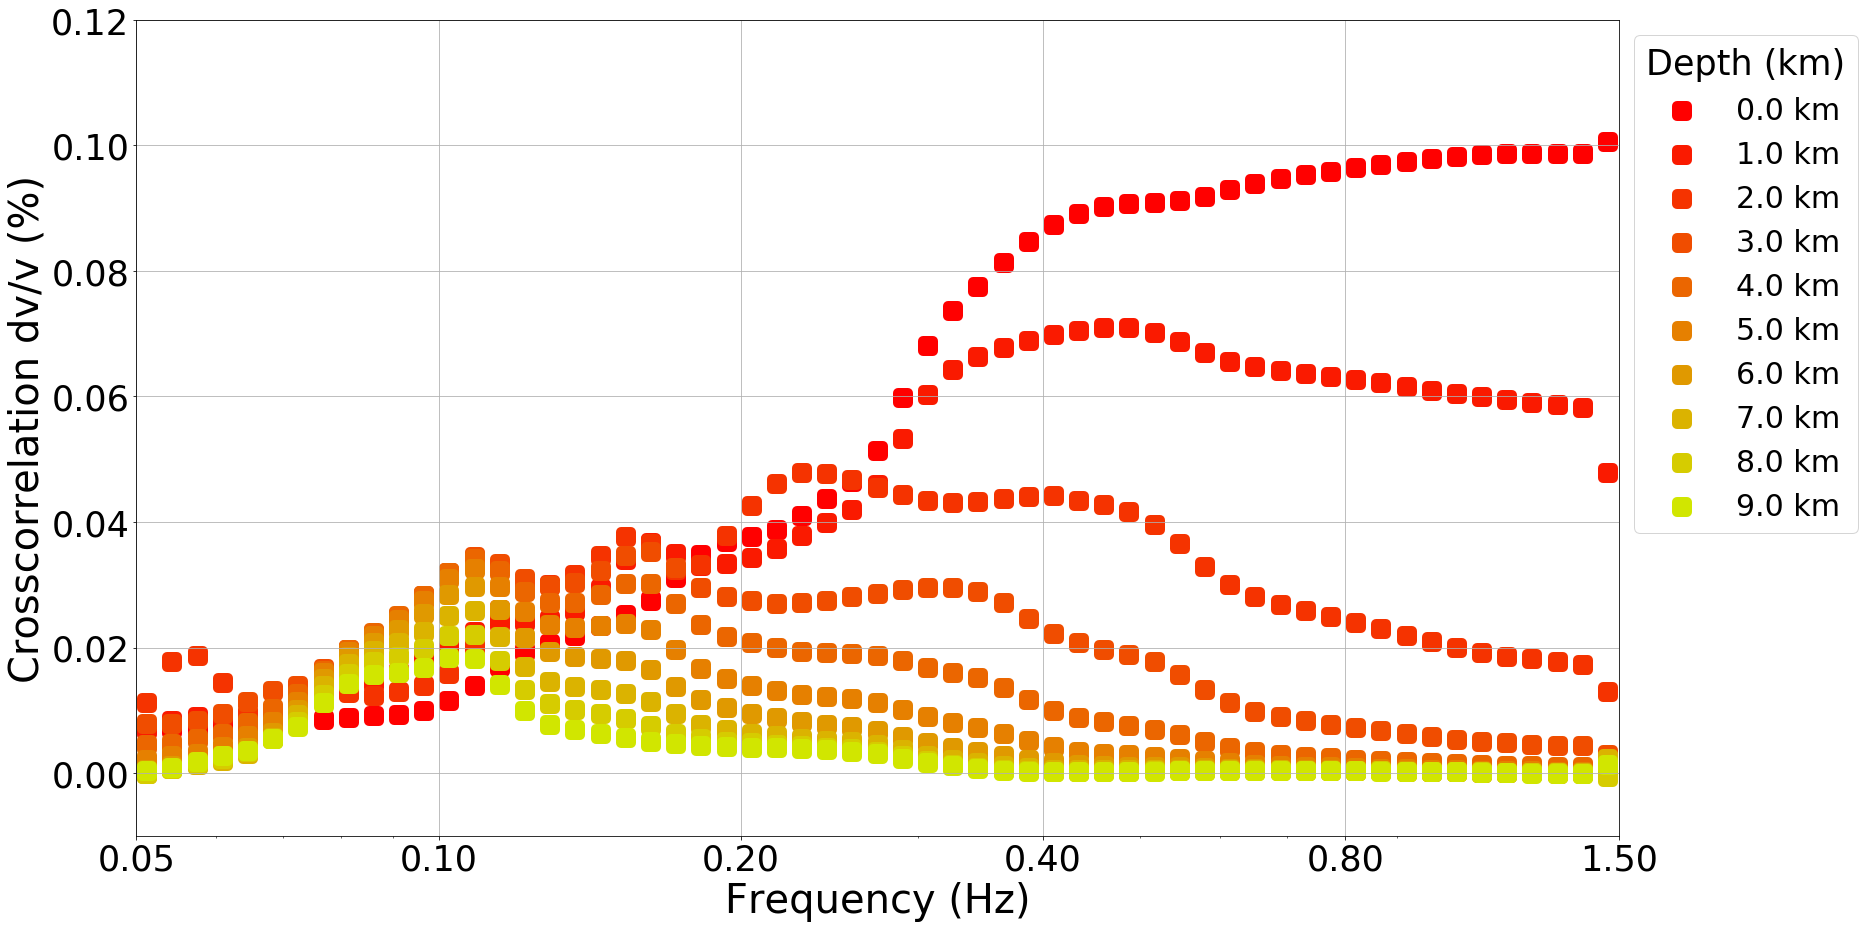

In [ ]:
# plot dv/v estimations
sflag = 'cc'
dvv_dict = {'dvv_wts_allfreqs': dvv_wts_allfreqs}
para = {'freq': [f_min02, f_max02], 'freq_vec': freqvec, 'dvov': dvov, 'dvov_range': dvov_range, 'sdep': ddep*dz, 'sflag': sflag}
plot_dvv_case02(dvv_dict, para)